In [1]:
import numpy as np
import json
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import cv2
import shutil
from tqdm import tqdm, trange
import scipy.ndimage as ndimage

regex = re.compile(r'\d+')


def black2white(img):
    img = img.copy()
    img[img == [0,0,0]] = 255
    return img

retinex_imgs = [cv2.imread(f'rf_trained_pred/retinex/{img}', cv2.IMREAD_GRAYSCALE) for img in tqdm(sorted(os.listdir('rf_trained_pred/retinex/'))) if regex.match(img)[0] not in ['0849','2089','1450']]
retinex_masks = [cv2.imread(f'rf_trained_pred/processed_mask/{img}', cv2.IMREAD_GRAYSCALE) for img in tqdm(sorted(os.listdir('rf_trained_pred/processed_mask/'))) if regex.match(img)[0] not in ['0849','2089','1450']]

def binarize_mask(mask):
    mask[mask>0] = 1
    return mask

retinex_masks = [binarize_mask(mask) for mask in tqdm(retinex_masks)]

100%|██████████| 2624/2624 [00:02<00:00, 929.37it/s] 


### Padding Them with the largest R, & C

In [127]:
largest_r = 0
largest_c = 0
for img in retinex_imgs:
    r, c = img.shape
    if r > largest_r:
        largest_r = r
    if c > largest_c:
        largest_c = c


def pad_img_gray(img, r, c):
    padded_img = np.ones((r, c))*255
    padded_img[:img.shape[0], :img.shape[1]] = img
    return padded_img

def pad_img_color(img, r, c):
    padded_img = np.ones((r, c, 3))*255
    padded_img[:img.shape[0], :img.shape[1], :] = img
    return padded_img

def pad_img(img, r, c):
    if len(img.shape) == 2:
        return pad_img_gray(img, r, c)
    else:
        return pad_img_color(img, r, c)


retinex_imgs = [pad_img(img, largest_r, largest_c) for img in tqdm(retinex_imgs)]
retinex_masks = [pad_img(mask, largest_r, largest_c) for mask in tqdm(retinex_masks)]

100%|██████████| 2624/2624 [00:16<00:00, 161.83it/s]


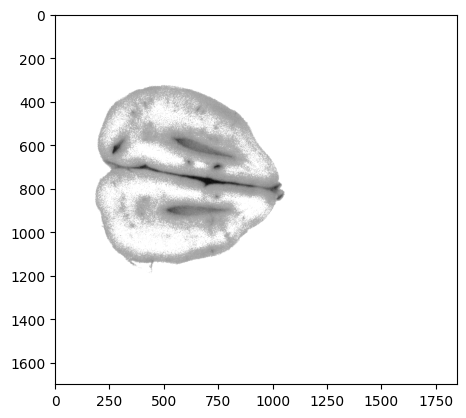

In [133]:
plt.imshow(retinex_imgs[500], cmap='gray')

In [134]:
def get_percentile(slide_idx, retinex_imgs=retinex_imgs,retinex_masks=retinex_masks, p=11):
    try:
        return np.percentile(retinex_imgs[slide_idx][retinex_masks[slide_idx]==1], np.linspace(0,100,p))
    except:
        print(f'Error in slide {slide_idx}')
        return None
    # return np.percentile(retinex_imgs[slide_idx][retinex_masks[slide_idx]==1], np.linspace(0,100,11))


percentiles = [get_percentile(slide_idx) for slide_idx in tqdm(range(len(retinex_imgs)))]
percentiles = [x for x in percentiles if x is not None]
percentiles = np.array(percentiles)

def plot_percentile_img(img, percentile):
    img = img.copy()
    img[img>percentile] = 255
    plt.imshow(img, cmap='gray')
    plt.title(f'Percentile {percentile}')
    plt.axis('off')
    plt.show()

100%|██████████| 2624/2624 [00:48<00:00, 54.07it/s] 

Error in slide 2622


In [135]:
ret_thresh = np.mean(percentiles, axis=0)[9]-5
def del_pixels_above_thresh(img, thresh=ret_thresh):
    img[img>thresh] = 255
    return img

retinex_imgs_thresh = [del_pixels_above_thresh(img) for img in tqdm(retinex_imgs)]

100%|██████████| 2624/2624 [00:12<00:00, 203.99it/s]


In [136]:
# Get Bounding Box
def img_to_bbox(img):
    img = img.copy()
    img[img<255] = 0
    img = ndimage.binary_fill_holes(img)
    img = img.astype(np.uint8)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Union all contours
    x,y,w,h = cv2.boundingRect(np.concatenate(contours))
    return x,y,w,h

retinex_bboxes = [img_to_bbox(img) for img in tqdm(retinex_imgs_thresh)]



100%|██████████| 2624/2624 [02:48<00:00, 15.54it/s]


In [137]:
# slide_idx = 330
discard_idx = []
frames = {}
rectangles = {}
for slide_idx in trange(len(retinex_imgs)):
    try:
        img = retinex_imgs_thresh[slide_idx].copy()
        img[img<255] = 1
        img[img==255] = 0
        img = ndimage.binary_fill_holes(img)
        img = ndimage.binary_erosion(img, iterations=5)
        img = img.astype(np.uint8)
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img = cv2.drawContours(retinex_imgs_thresh[slide_idx].copy(), contours, -1, 0, 3)
        x,y,w,h = cv2.boundingRect(np.concatenate(contours))
        # Draw bounding box
        frame = cv2.rectangle(img, (x,y), (x+w,y+h), 0, 3)
        frames[slide_idx] = frame
        rectangles[slide_idx] = (x,y,w,h)
    except ValueError as e:
        discard_idx.append(slide_idx)

100%|██████████| 2624/2624 [06:55<00:00,  6.32it/s]


In [166]:
# # Make gif with frames 
# frames__ = [frames[slide_idx] for slide_idx in frames]
# largest_r = max([frame.shape[0] for frame in frames__])
# largest_c = max([frame.shape[1] for frame in frames__])
# frames__ = [cv2.copyMakeBorder(frame, 0, largest_r-frame.shape[0], 0, largest_c-frame.shape[1], cv2.BORDER_CONSTANT, value=255) for frame in frames__]

## Make Video
# out = cv2.VideoWriter('retinex_bbox.avi', cv2.VideoWriter_fourcc(*'mp4v'), 120, (largest_c, largest_r))
# for frame in frames__:
#     out.write(frame)
# out.release()


rectangle_centers = [[x+w//2, y+h//2] for x,y,w,h in rectangles.values()]
# rectangle_centers = [[idx]+center for idx, center in enumerate(rectangle_centers)]
rectangle_centers = np.array(rectangle_centers)
# plt.scatter(rectangle_centers[:,0], rectangle_centers[:,1])
# new_centers = []
# # 20 frames from the start and end are buffered
# for idx, center in tqdm(enumerate(rectangle_centers)):
#     if idx in discard_idx or idx <20 or idx > len(rectangle_centers)-16:
#         continue
#     if new_centers:
#         new_centers_np = np.array(new_centers)[-4:]
#         new_centers_np_sum = new_centers_np.sum(axis=0)
#         rect_centers = rectangle_centers[idx+1:idx+3]
#         rect_centers_sum = rect_centers.sum(axis=0)
#         total_centers = len(new_centers_np) + len(rect_centers)
#         new_center = (new_centers_np_sum + rect_centers_sum)/total_centers
#         new_centers.append(new_center.tolist())
#     else:
#         new_center_ = rectangle_centers[idx-3:idx-1]
#         new_center = np.array(new_center_).sum(axis=0)/len(new_center_)
#         new_centers.append(new_center.tolist())
new_centers = []
for idx, center in tqdm(enumerate(rectangle_centers)):
    if idx in discard_idx or idx <20 or idx > len(rectangle_centers)-16:
        continue
    if len(new_centers)>0:
        new_center_np = np.array(new_centers)[-1]
        rect_center_np = rectangle_centers[idx] + rectangle_centers[idx+1]
        new_center = (new_center_np + rect_center_np)/3
        new_centers.append(new_center.tolist())
        # new_centers_np_sum = new_centers_np.sum(axis=0)
        # rect_centers = rectangle_centers[idx+1:idx+3]
        # rect_centers_sum = rect_centers.sum(axis=0)
        # total_centers = len(new_centers_np) + len(rect_centers)
        # new_center = (new_centers_np_sum + rect_centers_sum)/total_centers
        # new_centers.append(new_center.tolist())
    else:
        new_center = (rectangle_centers[idx-1]+ rectangle_centers[idx-2])/2
        new_centers.append(new_center.tolist())
    


2621it [00:00, 2656.85it/s]


In [174]:
import SimpleITK as sitk
import numpy as np

images = [sitk.GetImageFromArray(img) for img in tqdm(retinex_imgs_thresh)]


  0%|          | 0/2623 [00:00<?, ?it/s]


In [184]:

# Initialize the registration method
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings (you can also try other metrics like Mattes Mutual Information)
registration_method.SetMetricAsMeanSquares()

# Interpolator settings
registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings
registration_method.SetOptimizerAsRegularStepGradientDescent(
    learningRate=4.0,       # Adjusted learning rate
    minStep=1e-4,
    numberOfIterations=100,  # Fewer iterations since the parameter space is smaller
    gradientMagnitudeTolerance=1e-8
)

# List to store the cumulative transforms
transforms = []

# Use the first image as the reference (fixed image)
fixed_image = images[0]

# Start with the identity transform for the first image
identity_transform = sitk.Transform(fixed_image.GetDimension(), sitk.sitkIdentity)
transforms.append(identity_transform)

# Perform serial registration
for i in trange(1, len(images)):
    moving_image = images[i]
    try:

        # Initialize the transform for translation only
        initial_transform = sitk.TranslationTransform(fixed_image.GetDimension())
        registration_method.SetInitialTransform(initial_transform, inPlace=False)

        # Execute the registration
        final_transform = registration_method.Execute(fixed_image, moving_image)
        #  Cast the final transform to TranslationTransform
        # final_transform = sitk.TranslationTransform(final_transform)
        previous_parameters = transforms[-1].GetParameters()
        current_parameters = final_transform.GetParameters()
        if len(transforms[-1].GetParameters()) ==0 :
            previous_paramimport pickle 

with open(f'{output_dir}/transforms.pkl', 'wb') as f:
    pickle.dump(transforms, f)eters = (0,0)
        cumulative_parameters = [p + c for p, c in zip(previous_parameters, current_parameters)]
        # Create a new translation transform with the cumulative parameters
        cumulative_transform = sitk.TranslationTransform(fixed_image.GetDimension())
        cumulative_transform.SetParameters(cumulative_parameters)
        transforms.append(cumulative_transform)
    except Exception as e:
        print(f'Error in slide {i}')
        transforms.append(transforms[-1])
        continue
    fixed_image = moving_image


100%|██████████| 2623/2623 [43:54<00:00,  1.00s/it]


In [190]:
import pickle 

with open(f'{output_dir}/registration_method.pkl', 'wb') as f:
    pickle.dump(registration_method, f)

TypeError: cannot pickle 'SwigPyObject' object

In [191]:
import pickle 

with open(f'{output_dir}/transforms.pkl', 'wb') as f:
    pickle.dump(transforms, f)

In [185]:

# Resample images using cumulative transforms
registered_images = []
for i, (image, transform) in enumerate(zip(images, transforms)):
    resampled_image = sitk.Resample(
        image,
        images[0],
        transform,
        sitk.sitkLinear,
        255.0,
        image.GetPixelID()
    )
    registered_images.append(resampled_image)

In [187]:
os.makedirs('sitk_combined', exist_ok=True)
output_dir = 'sitk_combined'

# Combine the registered images into a 3D volume
if fixed_image.GetDimension() == 2:
    # Stack 2D images into a 3D volume
    volume = sitk.JoinSeries(registered_images)

    # Set the correct spacing for the volume (assuming uniform spacing between slices)
    slice_thickness = 1.0  # Replace with actual slice thickness if known
    spacing = list(fixed_image.GetSpacing()) + [slice_thickness]
    volume.SetSpacing(spacing)

    # Optionally, set the origin and direction
    origin = list(fixed_image.GetOrigin()) + [0.0]
    volume.SetOrigin(origin)

    direction = list(fixed_image.GetDirection())
    direction.extend([0]*len(direction))
    direction.extend([0]*(len(direction)//2))
    direction.append(1.0)
    # volume.SetDirection(direction)

    # Save the combined volume
    volume_output_path = os.path.join(output_dir, "registered_volume.nii.gz")
    sitk.WriteImage(volume, volume_output_path)
    print(f"Saved registered volume to {volume_output_path}")
else:
    print("Images are not 2D. Skipping volume construction.")

Saved registered volume to sitk_combined/registered_volume.nii.gz
